**Case 1: CO2 - Water**

<ipython-input-3-d31ba8938ae1>:33: RuntimeWarning: divide by zero encountered in divide
  return 1 / (1 + (visc1 / visc2) * (rel_perm['kr2'] / rel_perm['kr1']))


,S1,kr1,kr2,f1,vD,vD_plot
0,0.000,0.000000,1.000000e+00,0.000000,3.284678,6.491426
1,0.001,0.000328,9.962547e-01,0.003285,3.771128,6.491426
2,0.002,0.000754,9.925187e-01,0.007542,4.486054,6.491426
3,0.003,0.001227,9.887921e-01,0.012257,4.872407,6.491426
4,0.004,0.001733,9.850749e-01,0.017287,5.150988,6.491426
...,...,...,...,...,...,...
795,0.795,0.992505,2.441406e-07,1.000000,0.000015,0.000015
796,0.796,0.994003,1.250000e-07,1.000000,0.000010,0.000010
797,0.797,0.995502,5.273438e-08,1.000000,0.000006,0.000006
798,0.798,0.997001,1.562500e-08,1.000000,0.000003,0.000003


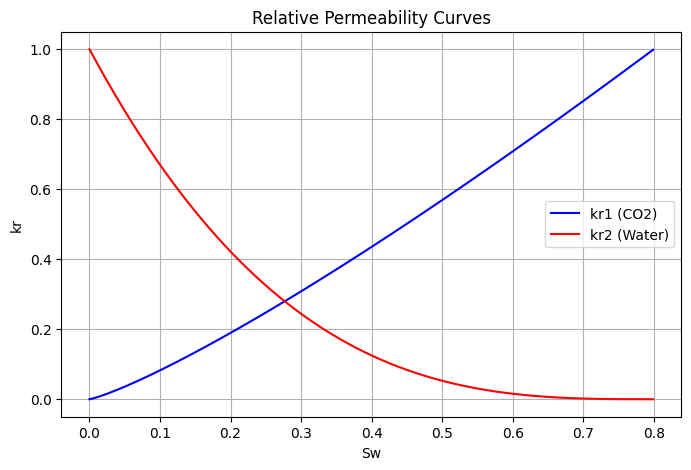

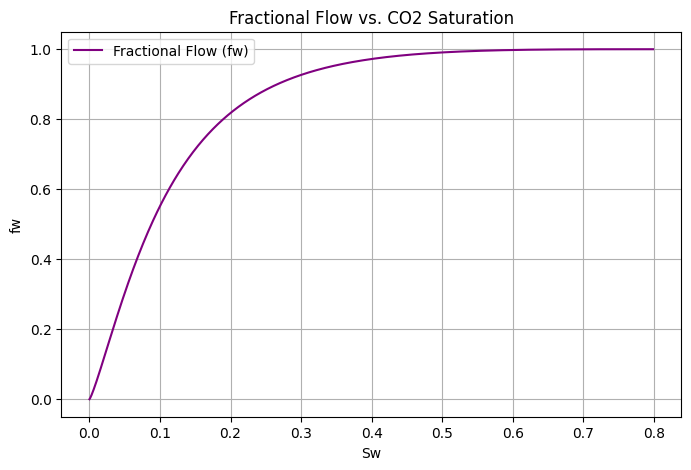

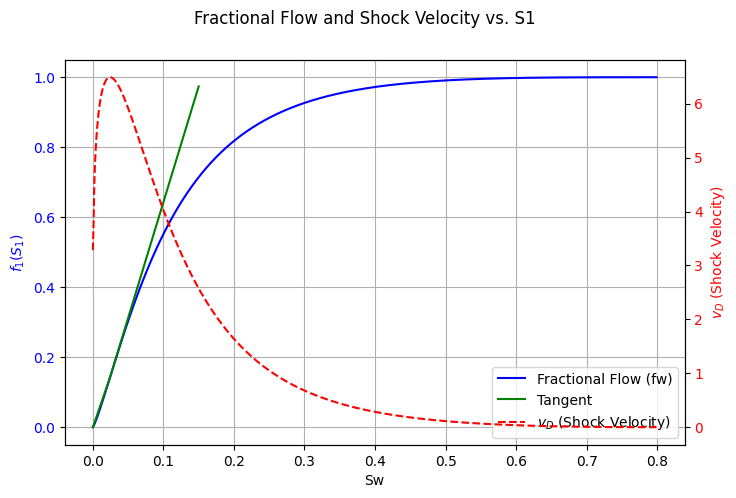

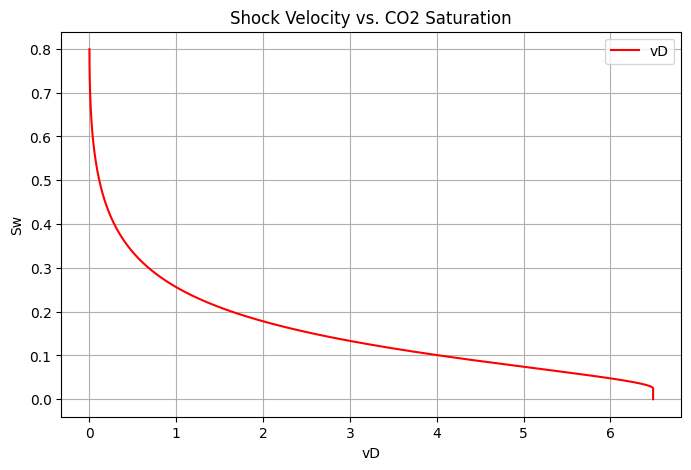

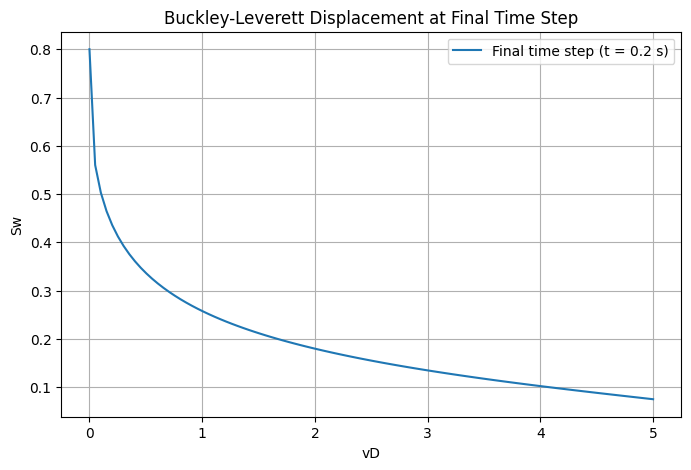

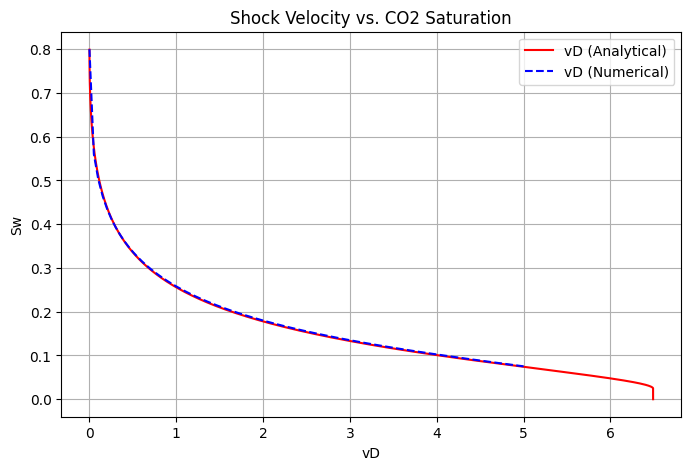

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for Case 1 (CO2 - Water)
visc1 = 0.1
visc2 = 1.0
kr1max = 1.0
kr2max = 1.0
a = 1.2
b = 3.0
S1i = 0.0
S2r = 0.2
delta_S1 = 0.001

# Generate saturation range
S1 = np.arange(S1i, 1 - S2r, delta_S1)

# Effective saturation function
def effective_saturation(S1, S1i, S2r):
    return (S1 - S1i) / (1 - S2r - S1i)

# Relative permeability functions
def relative_permeability(S1, a=1.2, b=3.0):
    Se = np.clip(effective_saturation(S1, S1i, S2r), 0, 1)
    kr1 = kr1max * Se ** a
    kr2 = kr2max * (1 - Se) ** b
    return {'kr1': kr1, 'kr2': kr2}

# Fractional flow function
def fractional_flow(S1):
    rel_perm = relative_permeability(S1)
    return 1 / (1 + (visc1 / visc2) * (rel_perm['kr2'] / rel_perm['kr1']))

# Derivative of fractional flow function
def df_dS1(S1, dS=1e-4):
    return (fractional_flow(S1 + dS) - fractional_flow(S1)) / dS

# Calculate relative permeability, fractional flow, and shock velocity
rel_perm = relative_permeability(S1)
f1 = fractional_flow(S1)
vD = np.gradient(f1, S1)

# Shock determination
tangent_shock = np.max(vD)
shock_index = np.argmax(vD)
S1_shock = S1[shock_index]
f1_shock = f1[shock_index]

# Tangent line for visualization
tan_x = [0, S1_shock, 0.15]
tan_y = [0, f1_shock, tangent_shock * 0.15]

# Prepare shock velocity plot
vD_plot = np.where(S1 > S1_shock, vD, tangent_shock)

# Dataframe for analysis
df = pd.DataFrame({"S1": S1,
                   "kr1": rel_perm['kr1'],
                   "kr2": rel_perm['kr2'],
                   "f1": f1,
                   "vD": vD,
                   "vD_plot": vD_plot})
display(df)

# ------------------------------
# 1) Plot Relative Permeability
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S1, rel_perm['kr1'], label='kr1 (CO2)', color='blue')
plt.plot(S1, rel_perm['kr2'], label='kr2 (Water)', color='red')
plt.xlabel('Sw')
plt.ylabel('kr')
plt.title('Relative Permeability Curves')
plt.legend()
plt.grid()
plt.show()

# ------------------------------------
# 2) NEW PLOT: Fractional Flow Only
# ------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S1, f1, label='Fractional Flow (fw)', color='purple')
plt.xlabel('Sw')
plt.ylabel('fw')
plt.title('Fractional Flow vs. CO2 Saturation')
plt.legend()
plt.grid()
plt.show()

# ---------------------------------------------
# 3) Plot Fractional Flow + Shock Velocity
# ---------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot lines on the first axis (ax1)
ax1.plot(S1, f1, label=r'Fractional Flow (fw)', color='blue')
ax1.plot(tan_x, tan_y, label='Tangent', color='green')
ax1.set_xlabel('Sw')
ax1.set_ylabel(r'$f_1(S_1)$', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# Create a twin axis (ax2) that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(S1, vD, label=r'$v_D$ (Shock Velocity)', color='red', linestyle='--')
ax2.set_ylabel(r'$v_D$ (Shock Velocity)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# -- Combine the legend entries from both axes --
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

fig.suptitle('Fractional Flow and Shock Velocity vs. S1')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(vD_plot, S1, color='red', label=r'vD')
plt.ylabel('Sw')
plt.xlabel(r'vD')
plt.title('Shock Velocity vs. CO2 Saturation')
plt.legend()
plt.grid()
plt.show()

# ------------------------------
# 4) Numerical Simulation
# ------------------------------
dx = 0.01  # Grid block size
dt = 0.001 # Time step size
Nx = 100   # Number of spatial grid blocks
Nt = 200   # Number of timesteps
L = Nx * dx
T = Nt * dt

# Define functions for relative permeability
def kr1(S1):
    return np.clip(kr1max * ((S1 - S1i) / (1 - S1i - S2r))**a, 0, kr1max)

def kr2(S1):
    return np.clip(kr2max * ((1 - S1 - S2r) / (1 - S1i - S2r))**b, 0, kr2max)

# Function for fractional flow
def fw(S1):
    kr1_val = kr1(S1)
    kr2_val = kr2(S1)
    return (kr1_val / visc1) / ((kr1_val / visc1) + (kr2_val / visc2))

x = np.linspace(0, L, Nx)
S1_num = np.zeros((Nt, Nx))
S1_num[0, :] = S1i
S1_inj = 1 - S2r

for n in range(1, Nt):
    S1_num[n] = S1_num[n-1].copy()
    S1_num[n, 0] = S1_inj
    for i in range(1, Nx):
        S1_num[n, i] = S1_num[n-1, i] - (dt/dx) * (fw(S1_num[n-1, i]) - fw(S1_num[n-1, i-1]))

vD_num = x / T

plt.figure(figsize=(8, 5))
plt.plot(vD_num, S1_num[-1], label=f'Final time step (t = {T:.1f} s)')
plt.xlabel('vD')
plt.ylabel('Sw')
plt.title('Buckley-Leverett Displacement at Final Time Step')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(vD_plot, S1, color='red', label='vD (Analytical)')
plt.plot(vD_num, S1_num[-1], color='blue', linestyle='dashed', label='vD (Numerical)')
plt.xlabel('vD')
plt.ylabel('Sw')
plt.title('Shock Velocity vs. CO2 Saturation')
plt.legend()
plt.grid()
plt.show()

**Case 2: Water - H2**

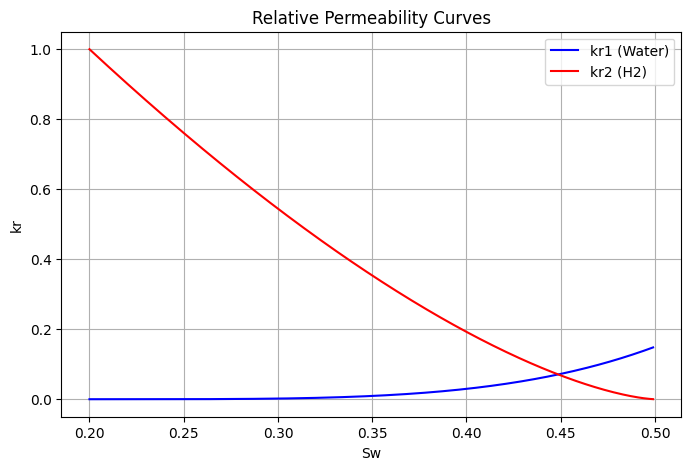

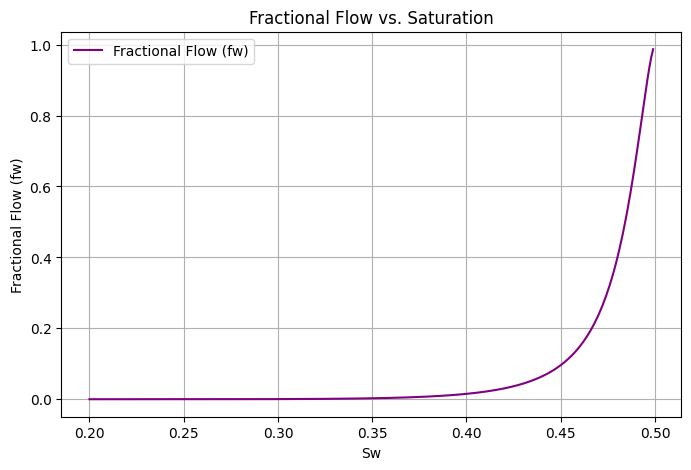

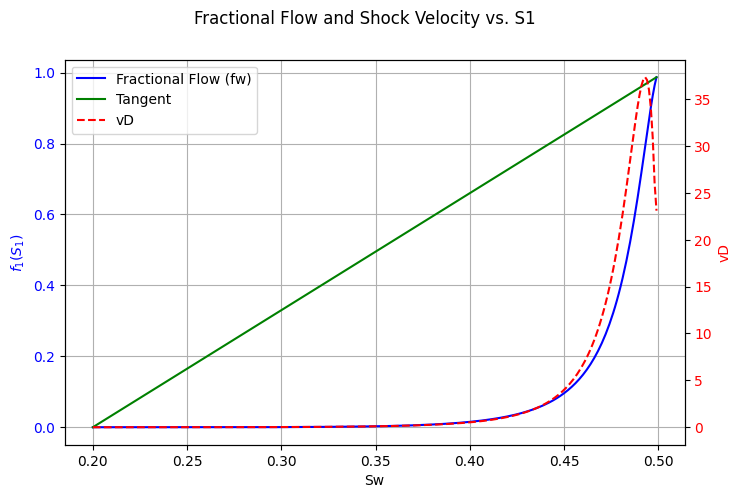

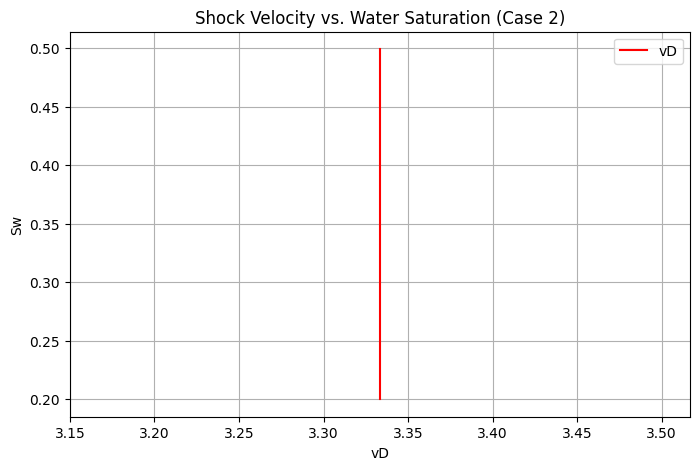

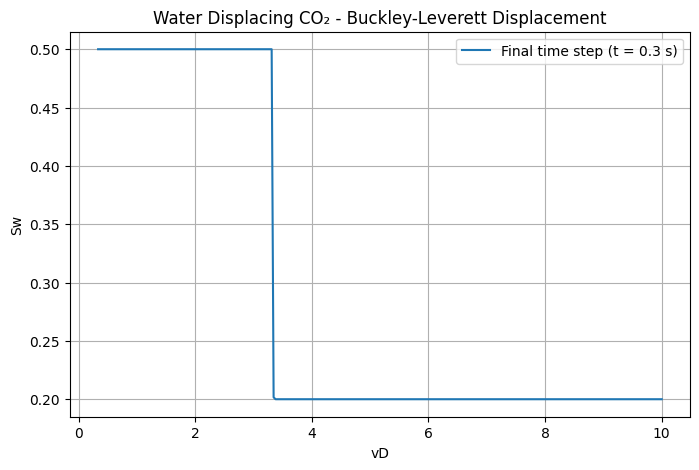

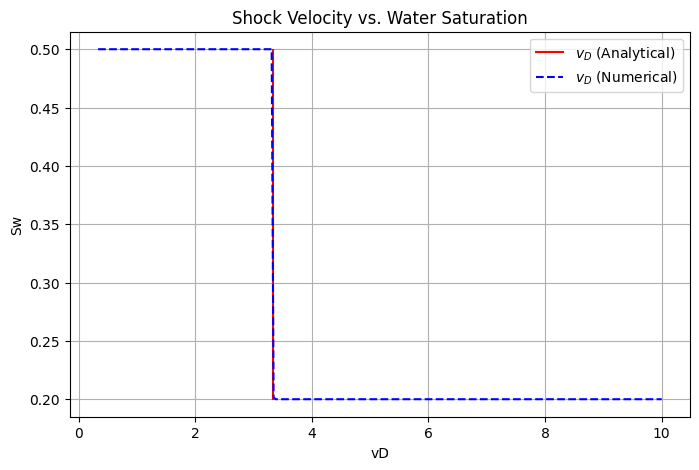

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for Case 2 (Water-H2)
visc1 = 1.0  # Water viscosity (mPa.s)
visc2 = 0.1  # CO₂ viscosity (mPa.s)
kr1max = 0.15
kr2max = 1.0
a = 4          # Corey exponent for Water
b = 1.5        # Corey exponent for CO₂
S1i = 0.2
S2r = 0.5
delta_S1 = 0.001

# Generate saturation range
S1 = np.arange(S1i, 1 - S2r, delta_S1)

# Effective saturation function
def effective_saturation(S1, S1i, S2r):
    return (S1 - S1i) / (1 - S2r - S1i)

# Relative permeability functions
def relative_permeability(S1, a=4, b=1.5):
    Se = np.clip(effective_saturation(S1, S1i, S2r), 0, 1)
    kr1 = np.clip(kr1max * Se ** a, 0, kr1max)
    kr2 = np.clip(kr2max * (1 - Se) ** b, 0, kr2max)
    return {'kr1': kr1, 'kr2': kr2}

# Fractional flow function
def fractional_flow(S1):
    rel_perm = relative_permeability(S1)
    denominator = (rel_perm['kr1'] / visc1) + (rel_perm['kr2'] / visc2)
    return np.where(denominator != 0, (rel_perm['kr1'] / visc1) / denominator, 0)

# Calculate relative permeability, fractional flow, and shock velocity
rel_perm = relative_permeability(S1)
f1 = fractional_flow(S1)
vD = np.gradient(f1, S1)

# Shock determination
shock = [0]
for j in range(1, len(S1)):
    shock.append(f1[j]/(S1[j]-S1i))
tangent_shock = 1/(1-S1i-S2r)
shock_index = np.argmax(shock)
S1_shock = S1[shock_index]
f1_shock = f1[shock_index]

# Tangent line for visualization
tan_x = [S1i, S1_shock]
tan_y = [0, f1_shock]

# Prepare shock velocity plot
vD_plot = np.where(S1 > S1_shock, vD, tangent_shock)

# Numerical Simulation for Buckley-Leverett
dx = 0.01 # Grid block size
dt = 0.001 # Time step size
Nx = 300 # Number of spatial grid blocks
Nt = 300 # Number of timesteps
L = Nx * dx
T = Nt * dt
x = np.linspace(0, L, Nx)

S1_num = np.zeros((Nt, Nx))
S1_num[0, :] = S1i
S1_inj = 1 - S2r

for n in range(1, Nt):
    S1_num[n] = S1_num[n-1].copy()
    S1_num[n, 0] = S1_inj
    for i in range(1, Nx):
        fw_diff = fractional_flow(S1_num[n-1, i]) - fractional_flow(S1_num[n-1, i-1])
        S1_num[n, i] = S1_num[n-1, i] - (dt/dx) * fw_diff

vD_num = x / T


# Plot Numerical vs Analytical
# ------------------------------
# 1) Plot Relative Permeability
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S1, rel_perm['kr1'], label='kr1 (Water)', color='blue')
plt.plot(S1, rel_perm['kr2'], label='kr2 (H2)', color='red')
plt.xlabel('Sw')
plt.ylabel('kr')
plt.title('Relative Permeability Curves')
plt.legend()
plt.grid()
plt.show()

# ------------------------------------
# 2) NEW PLOT: Fractional Flow Only
# ------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S1, f1, label='Fractional Flow (fw)', color='purple')
plt.xlabel('Sw')
plt.ylabel('Fractional Flow (fw)')
plt.title('Fractional Flow vs. Saturation')
plt.legend()
plt.grid()
plt.show()

# ---------------------------------------------
# 3) Plot Fractional Flow + Shock Velocity
# ---------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot lines on the first axis (ax1)
ax1.plot(S1, f1, label=r'Fractional Flow (fw)', color='blue')
ax1.plot(tan_x, tan_y, label='Tangent', color='green')
ax1.set_xlabel('Sw')
ax1.set_ylabel(r'$f_1(S_1)$', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# Create a twin axis (ax2) that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(S1, vD, label=r'vD', color='red', linestyle='--')
ax2.set_ylabel(r'vD', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# -- Combine the legend entries from both axes --
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

fig.suptitle('Fractional Flow and Shock Velocity vs. S1')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(vD_plot, S1, color='red', label=r'vD')
plt.xlabel(r'vD')
plt.ylabel('Sw')
plt.title('Shock Velocity vs. Water Saturation (Case 2)')
plt.legend()
plt.grid()
plt.show()

# Updated Plot: Water Displacing CO₂ - Buckley-Leverett Displacement
plt.figure(figsize=(8, 5))
plt.plot(vD_num[10:], S1_num[-1, 10:], label=f'Final time step (t = {T:.1f} s)')
plt.xlabel('vD')
plt.ylabel('Sw')
plt.title('Water Displacing CO₂ - Buckley-Leverett Displacement')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(vD_plot, S1, color='red', label=r'$v_D$ (Analytical)')
plt.plot(vD_num[10:], S1_num[-1, 10:], color='blue', linestyle='dashed', label=r'$v_D$ (Numerical)')
plt.xlabel('vD')
plt.ylabel('Sw')
plt.title('Shock Velocity vs. Water Saturation')
plt.legend()
plt.grid()
plt.show()

**Case 3: Water - CO2**

,S1,kr1,kr2,f1,vD,vD_plot
0,0.200,0.000000e+00,0.800000,0.000000e+00,7.018747e-10,1.538462
1,0.201,2.240818e-12,0.798155,7.018747e-13,5.628000e-09,1.538462
2,0.202,3.585309e-11,0.796311,1.125600e-11,2.820689e-08,1.538462
3,0.203,1.815062e-10,0.794468,5.711566e-11,8.483851e-08,1.538462
4,0.204,5.736494e-10,0.792627,1.809330e-10,1.928215e-07,1.538462
...,...,...,...,...,...,...
645,0.845,3.878336e-01,0.000540,9.944642e-01,1.683150e+00,1.538462
646,0.846,3.902444e-01,0.000386,9.960571e-01,1.493507e+00,1.538462
647,0.847,3.926664e-01,0.000251,9.974512e-01,1.281237e+00,1.281237
648,0.848,3.950996e-01,0.000137,9.986196e-01,1.031636e+00,1.031636


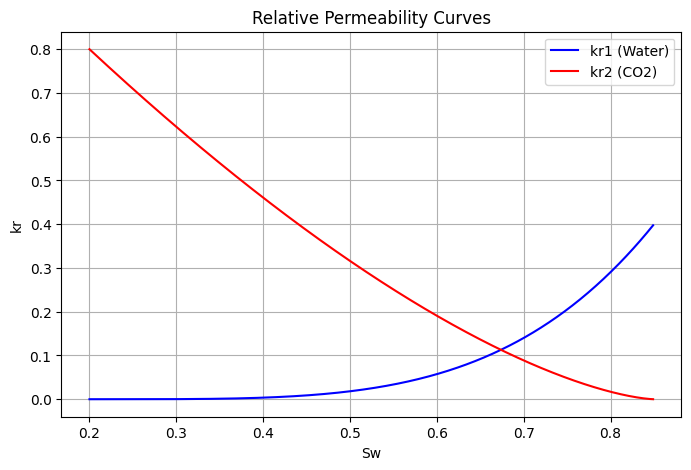

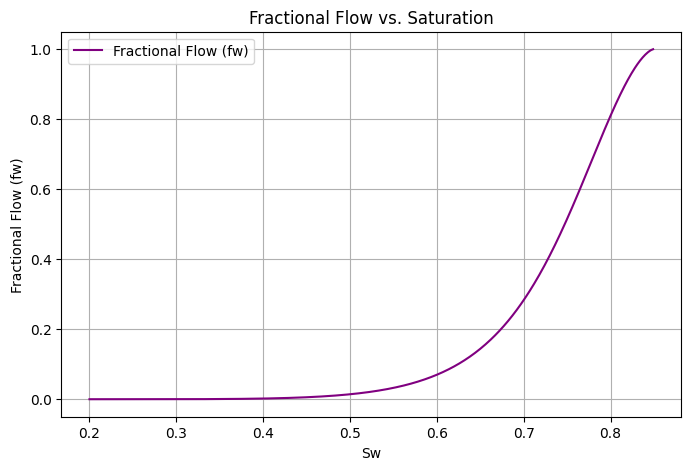

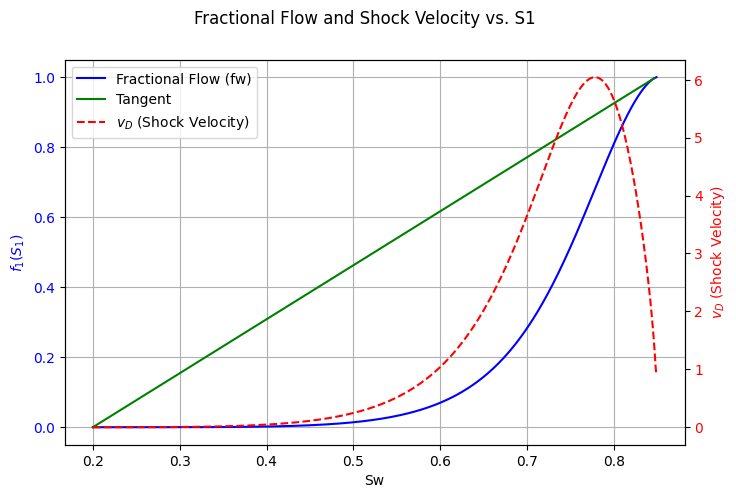

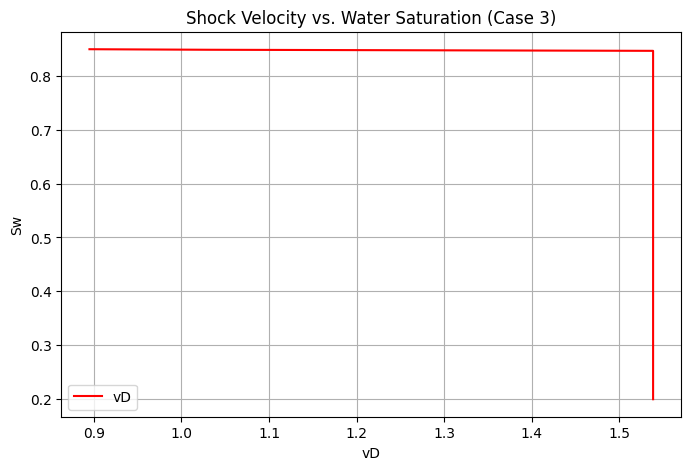

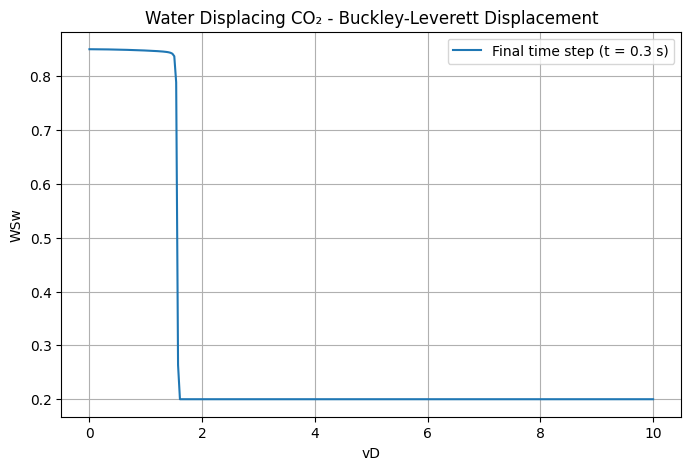

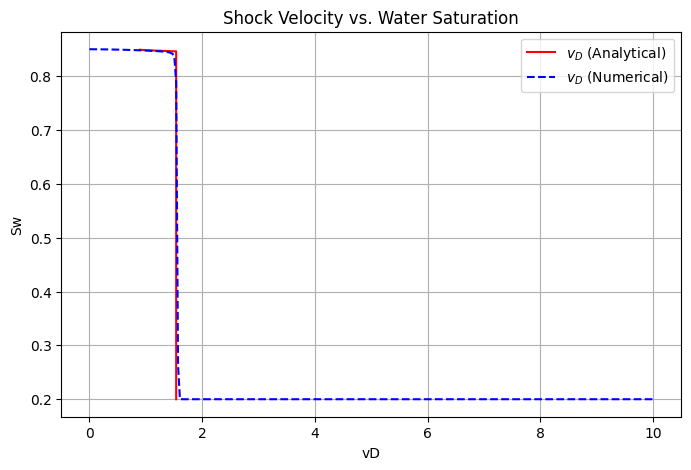

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for Case 3 (Water-CO₂)
visc1 = 0.4  # Water viscosity (mPa.s)
visc2 = 0.1  # CO₂ viscosity (mPa.s)
kr1max = 0.4
kr2max = 0.8
a = 8          # Corey exponent for Water
b = 3        # Corey exponent for CO₂
S1i = 0.2
S2r = 0.15
delta_S1 = 0.001

# Generate saturation range
S1 = np.arange(S1i, 1 - S2r, delta_S1)

# Effective saturation function
def effective_saturation(S1, S1i, S2r):
    return (S1 - S1i) / (1 - S2r - S1i)

# Relative permeability functions
def relative_permeability(S1, a=4, b=1.5):
    Se = np.clip(effective_saturation(S1, S1i, S2r), 0, 1)
    kr1 = np.clip(kr1max * Se ** a, 0, kr1max)
    kr2 = np.clip(kr2max * (1 - Se) ** b, 0, kr2max)
    return {'kr1': kr1, 'kr2': kr2}

# Fractional flow function
def fractional_flow(S1):
    rel_perm = relative_permeability(S1)
    denominator = (rel_perm['kr1'] / visc1) + (rel_perm['kr2'] / visc2)
    return np.where(denominator != 0, (rel_perm['kr1'] / visc1) / denominator, 0)

# Calculate relative permeability, fractional flow, and shock velocity
rel_perm = relative_permeability(S1)
f1 = fractional_flow(S1)
vD = np.gradient(f1, S1)

# Shock determination
shock = [0]
for j in range(1, len(S1)):
    shock.append(f1[j]/(S1[j]-S1i))
tangent_shock = 1/(1-S1i-S2r)
shock_index = np.argmax(shock)
S1_shock = S1[shock_index]
f1_shock = f1[shock_index]

# Tangent line for visualization
tan_x = [S1i, S1_shock]
tan_y = [0, f1_shock]

# Prepare shock velocity plot
vD_plot = np.where(S1 > S1_shock, vD, tangent_shock)

# Dataframe for analysis
df = pd.DataFrame({"S1": S1, "kr1": rel_perm['kr1'], "kr2": rel_perm['kr2'], "f1": f1, "vD": vD, "vD_plot": vD_plot})
display(df)

# Numerical Simulation for Buckley-Leverett
dx = 0.01 # Grid block size
dt = 0.001 # Time step size
Nx = 300 # Number of spatial grid blocks
Nt = 300 # Number of timesteps
L = Nx * dx
T = Nt * dt
x = np.linspace(0, L, Nx)

S1_num = np.zeros((Nt, Nx))
S1_num[0, :] = S1i
S1_inj = 1 - S2r

for n in range(1, Nt):
    S1_num[n] = S1_num[n-1].copy()
    S1_num[n, 0] = S1_inj
    for i in range(1, Nx):
        fw_diff = fractional_flow(S1_num[n-1, i]) - fractional_flow(S1_num[n-1, i-1])
        S1_num[n, i] = S1_num[n-1, i] - (dt/dx) * fw_diff

vD_num = x / T

# Plot Numerical vs Analytical
# ------------------------------
# 1) Plot Relative Permeability
# ------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S1, rel_perm['kr1'], label='kr1 (Water)', color='blue')
plt.plot(S1, rel_perm['kr2'], label='kr2 (CO2)', color='red')
plt.xlabel('Sw')
plt.ylabel('kr')
plt.title('Relative Permeability Curves')
plt.legend()
plt.grid()
plt.show()

# ------------------------------------
# 2) Plot Fractional Flow Only
# ------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S1, f1, label='Fractional Flow (fw)', color='purple')
plt.xlabel('Sw')
plt.ylabel('Fractional Flow (fw)')
plt.title('Fractional Flow vs. Saturation')
plt.legend()
plt.grid()
plt.show()

# ---------------------------------------------
# 3) Plot Fractional Flow + Shock Velocity
# ---------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot lines on the first axis (ax1)
ax1.plot(S1, f1, label=r'Fractional Flow (fw)', color='blue')
ax1.plot(tan_x, tan_y, label='Tangent', color='green')
ax1.set_xlabel('Sw')
ax1.set_ylabel(r'$f_1(S_1)$', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# Create a twin axis (ax2) that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(S1, vD, label=r'$v_D$ (Shock Velocity)', color='red', linestyle='--')
ax2.set_ylabel(r'$v_D$ (Shock Velocity)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# -- Combine the legend entries from both axes --
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

fig.suptitle('Fractional Flow and Shock Velocity vs. S1')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(vD_plot, S1, color='red', label=r'vD')
plt.xlabel(r'vD')
plt.ylabel('Sw')
plt.title('Shock Velocity vs. Water Saturation (Case 3)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(vD_num, S1_num[-1], label=f'Final time step (t = {T:.1f} s)')
plt.xlabel('vD')
plt.ylabel('WSw')
plt.title('Water Displacing CO₂ - Buckley-Leverett Displacement')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(vD_plot, S1, color='red', label=r'$v_D$ (Analytical)')
plt.plot(vD_num, S1_num[-1], color='blue', linestyle='dashed', label=r'$v_D$ (Numerical)')
plt.xlabel('vD')
plt.ylabel('Sw')
plt.title('Shock Velocity vs. Water Saturation')
plt.legend()
plt.grid()
plt.show()

In [11]:
C_case3

0.0001348653114543784